In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from skimage.io import imread

## Estimate 2D metrics

In [15]:
def projection(pcd, max_obstacle_height=1.5):
    pcd = np.round(pcd / 0.05) * 0.05
    max_npoints = 0
    ground_z = None
    zs = np.unique(pcd[:, 2])
    for z in zs:
        if z > 0.5 * (zs.min() + zs.max()):
            continue
        n_points = len(pcd[pcd[:, 2] == z])
        if n_points > max_npoints:
            max_npoints = n_points
            ground_z = z
    
    ground_points = pcd[(pcd[:, 2] >= ground_z - 0.1) * (pcd[:, 2] <= ground_z + 0.1)]
    obst_points = pcd[(pcd[:, 2] > ground_z + 0.1) * (pcd[:, 2] < ground_z + max_obstacle_height)]
    ground_proj = np.round(ground_points[:, :2] / 0.05).astype(np.int32)
    ground_proj = np.array(list(set(map(tuple, ground_proj))))
    obst_proj = np.round(obst_points[:, :2] / 0.05).astype(np.int32)
    obst_proj = np.array(list(set(map(tuple, obst_proj))))
    
    min_coord = np.minimum(ground_proj.min(axis=0), obst_proj.min(axis=0))
    max_coord = np.maximum(ground_proj.max(axis=0), obst_proj.max(axis=0))
    h, w = max_coord - min_coord + 1
    
    gt_projmap = np.ones((w, h), dtype=np.uint8) * 127
    ground_proj -= min_coord
    obst_proj -= min_coord
    gt_projmap[ground_proj[:, 1], ground_proj[:, 0]] = 255
    gt_projmap[obst_proj[:, 1], obst_proj[:, 0]] = 0
    return gt_projmap, min_coord

In [7]:
for i in range(1, 21):
    for map_name in ['first', 'second']:
        gt_map_fn = 'sample{}/{}_map_rgbdslam_kinect.pcd'
        

In [8]:
def rotate(points, angle):
    res = points.copy()
    res[:, 0] = points[:, 0] * np.cos(angle) + points[:, 1] * np.sin(angle)
    res[:, 1] = -points[:, 0] * np.sin(angle) + points[:, 1] * np.cos(angle)
    return res

In [9]:
def align_points(slam_map, gt_map, x, y, angle, map_x, map_y, shift, scale):
    points = np.array((slam_map == 0).nonzero()).T.astype(np.float32)
    points[:, 0] += map_y * 20
    points[:, 1] += map_x * 20
    points_rotated = rotate(points, angle)
    points_transformed = points_rotated / scale
    points_transformed[:, 0] += -shift[1] + y * 20
    points_transformed[:, 1] += -shift[0] + x * 20
    gt_points = np.array((gt_projmap == 0).nonzero()).T.astype(np.float32)
    #plt.figure(figsize=(12, 7))
    plt.imshow(gt_map, cmap='gray')
    plt.scatter(points_transformed[:, 1], points_transformed[:, 0], s=10, alpha=0.2, color='r')
    plt.show()
    return points_transformed, gt_points

In [10]:
def compare(slam_map, gt_map, x, y, angle, map_x, map_y, shift, scale=1):
    slam_points, gt_points = align_points(slam_map, gt_map, x, y, angle, map_x, map_y, shift, scale)
    sum_dst = 0
    for pt in slam_points:
        dst = np.sqrt(np.sum((gt_points - pt) ** 2, axis=1)).min()
        sum_dst += dst
    return sum_dst * 0.05 / len(slam_points)

In [11]:
def compare_points(slam_points, gt_points):
    sum_dst = 0
    for pt in slam_points:
        dst = np.sqrt(np.sum((gt_points - pt) ** 2, axis=1)).min()
        sum_dst += dst
    return sum_dst * 0.05 / len(slam_points)

In [12]:
first_pcd = np.loadtxt('sample18/kinect_points_first.txt')
second_pcd = np.loadtxt('sample18/kinect_points_second.txt')
merged_pcd = np.loadtxt('sample18/mm2_results/merged_points.txt')

OSError: sample18/kinect_points_first.txt not found.

In [13]:
for i in range(1, 21):
    merged_pcd = np.loadtxt('sample{}/gt_points_merged.txt'.format(i))
    projmap, _ = projection(merged_pcd)
    print(i, projmap.shape)

1 (397, 476)
2 (456, 544)
3 (267, 462)
4 (489, 448)


KeyboardInterrupt: 

In [27]:
first_pcd = rotate(first_pcd, 0.5)
second_pcd = rotate(second_pcd, 2.9)
merged_pcd = rotate(merged_pcd, 2.9)

In [28]:
first_projmap, _ = projection(first_pcd)
second_projmap, _ = projection(second_pcd)
merged_projmap, _ = projection(merged_pcd)

[11.8685915   1.96317362  1.35094   ] -1.35966
[11.67148676  5.99358492  1.2612    ] -1.35848
[11.67148676  5.99358492  1.4202    ] -1.36702


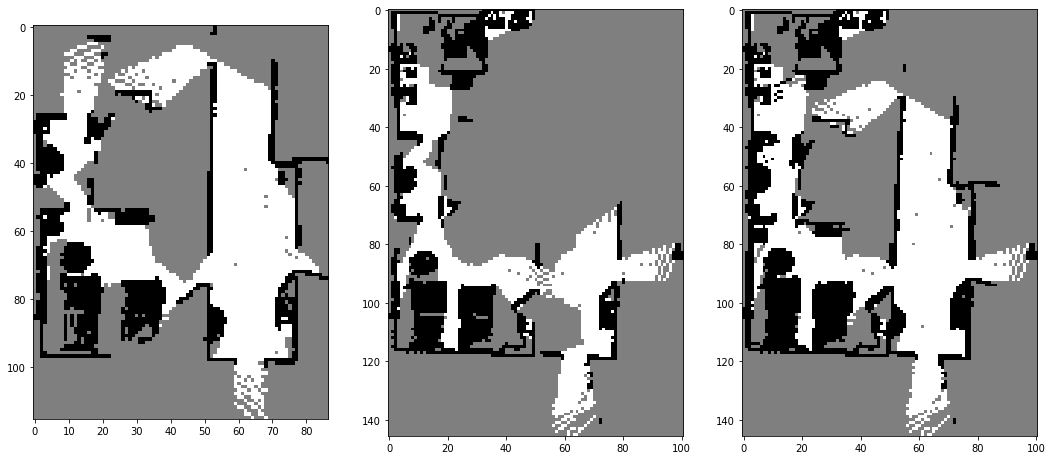

In [30]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
plt.imshow(first_projmap.T, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(second_projmap.T, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(merged_projmap.T, cmap='gray')
plt.savefig('slam_projmaps.png')

## Estimate for individual maps

In [43]:
correction = [-0.45,
 -0.45,
 -0.45,
 -0.45,
 1.51,
 1.51,
 1.51,
 1.51,
 -0.37,
 -0.37,
 -0.37,
 0.06,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07]

In [352]:
map_x, map_y

(-0.5249999761581421, -12.324999809265137)

In [379]:
best_scales = {
'sample1/first': 1.18,
 'sample1/second': 1.11,
 'sample2/first': 1.18,
 'sample2/second': 1.18,
 'sample3/first': 1.43,
 'sample3/second': 1.39,
 'sample4/first': 1.11,
 'sample4/second': 1.0,
 'sample5/first': 1.33,
 'sample5/second': 1.43,
 'sample6/first': 1.33,
 'sample6/second': 1.43,
 'sample7/first': 1.33,
 'sample7/second': 1.43,
 'sample8/first': 1.32,
 'sample8/second': 1.39,
 'sample9/first': 1.43,
 'sample9/second': 1.59,
 'sample10/first': 1.05,
 'sample10/second': 1.33,
 'sample11/first': 1.59,
 'sample11/second': 1.37,
'sample12/first': 1.05,
 'sample12/second': 1.2,
 'sample13/first': 1.2,
 'sample13/second': 1.2,
 'sample14/first': 1.15,
 'sample14/second': 1.05,
 'sample15/first': 1.2,
 'sample15/second': 1.45,
 'sample16/first': 1.8,
 'sample16/second': 1.3,
 'sample17/first': 1.55,
 'sample17/second': 1.75,
 'sample18/first': 1.6,
 'sample18/second': 1.55,
 'sample19/first': 1.55,
 'sample19/second': 1.5,
 'sample20/first': 1.45,
 'sample20/second': 1.8}

Sample 1


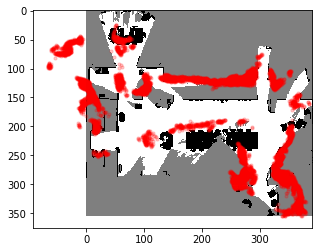

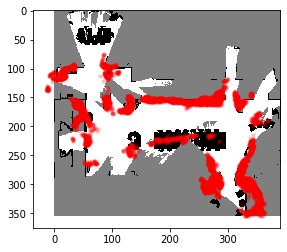

first cc = 0.6369729933438221; first scaled cc = 0.2804161535721057


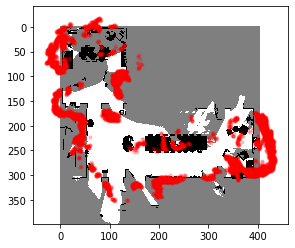

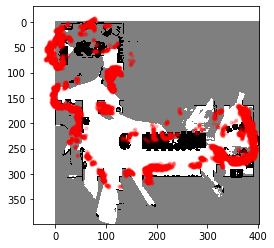

second cc = 0.5761775417598544; second scaled cc = 0.34551107371434986
Sample 2


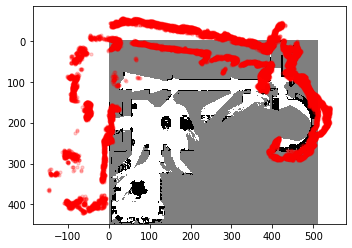

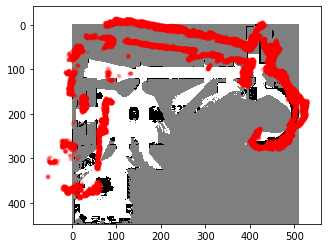

first cc = 2.443114739838595; first scaled cc = 1.391254883369151


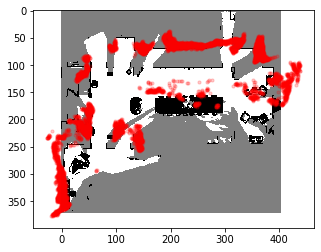

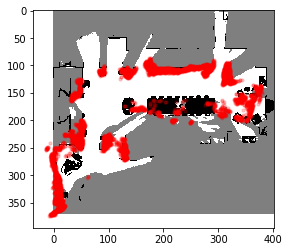

second cc = 0.514300037975917; second scaled cc = 0.18548597215975687
Sample 3


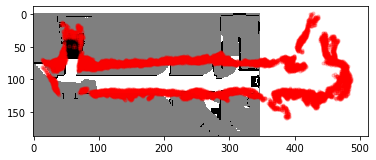

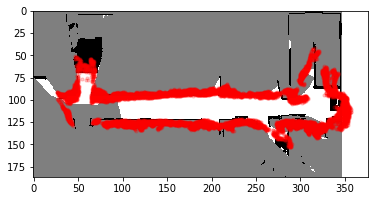

first cc = 1.7352664119295362; first scaled cc = 0.223983592603884


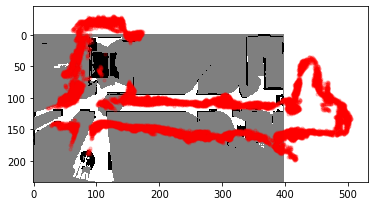

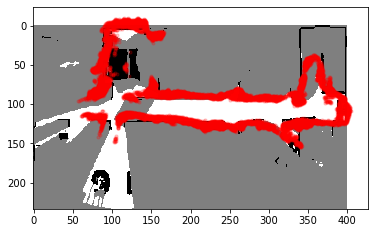

second cc = 1.260490387376838; second scaled cc = 0.21853300391810768
Sample 4


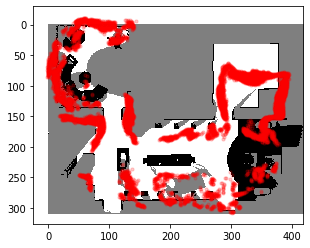

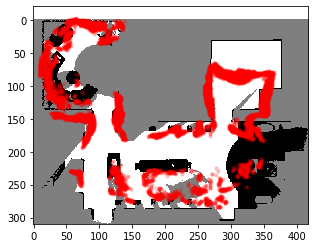

first cc = 0.47897112968889344; first scaled cc = 0.39479987611953077


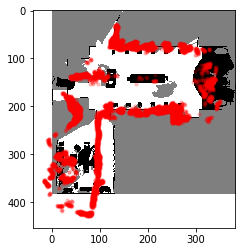

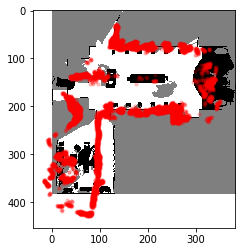

second cc = 0.42895392283826267; second scaled cc = 0.42895392283826267
Sample 5


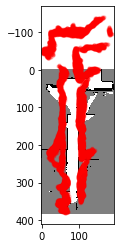

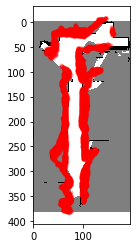

first cc = 1.6196893725552677; first scaled cc = 0.25860315175053106


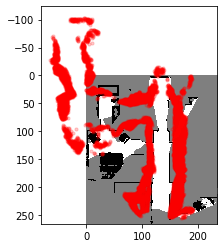

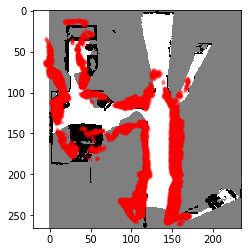

second cc = 1.2412553476105532; second scaled cc = 0.28230655127438503
Sample 6


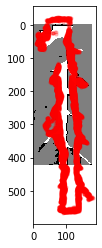

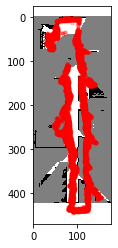

first cc = 1.1994725224562428; first scaled cc = 0.351186588748133


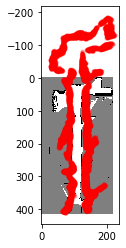

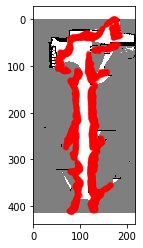

second cc = 1.9597819249461195; second scaled cc = 0.2512512922227317
Sample 7


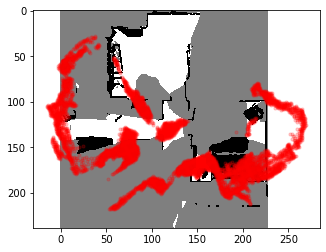

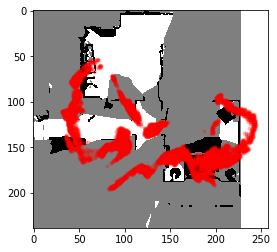

first cc = 0.6206600863213427; first scaled cc = 0.33860250563928806


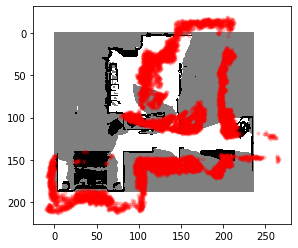

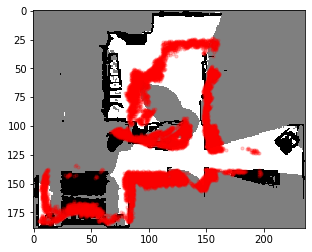

second cc = 0.7480764627772604; second scaled cc = 0.3311820875212517
Sample 8


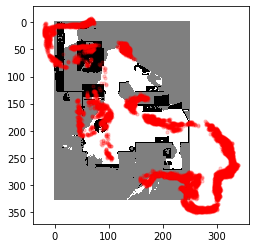

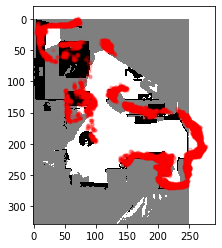

first cc = 1.731195847013118; first scaled cc = 0.2626386622861807


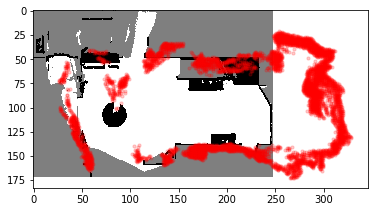

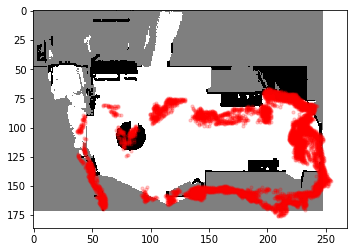

second cc = 1.5169461509153328; second scaled cc = 0.49761778655452354
Sample 9


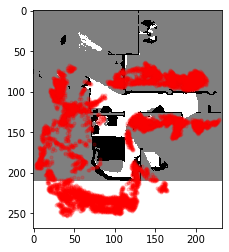

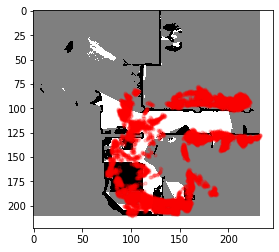

first cc = 1.0815013805272862; first scaled cc = 0.30243650799302896


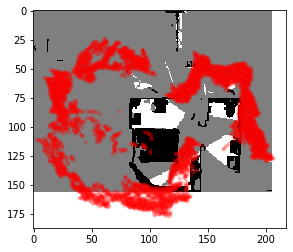

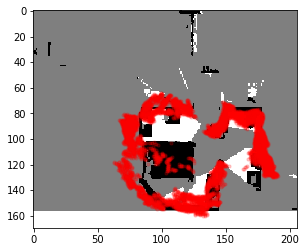

second cc = 0.9297047280412811; second scaled cc = 0.15636415583559796
Sample 10


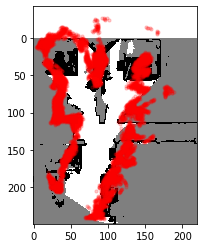

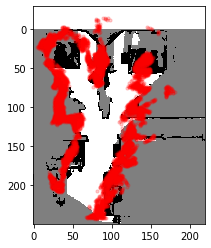

first cc = 0.26290974520268123; first scaled cc = 0.2565838466728798


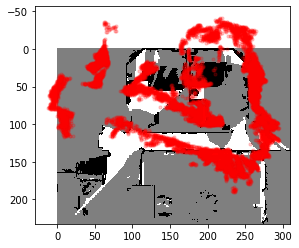

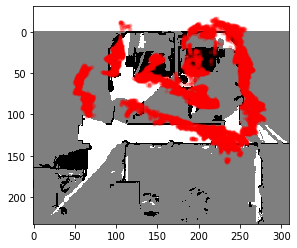

second cc = 0.7810041736190451; second scaled cc = 0.2937781125560997
Sample 11


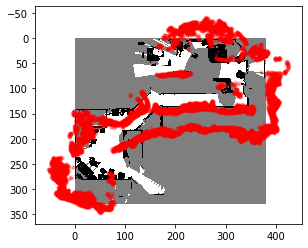

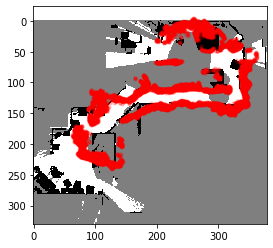

first cc = 1.1513561547593023; first scaled cc = 0.21484655662499375


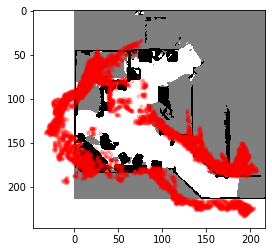

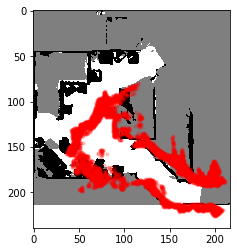

second cc = 0.38804256889204886; second scaled cc = 0.33340811257695957
Sample 12


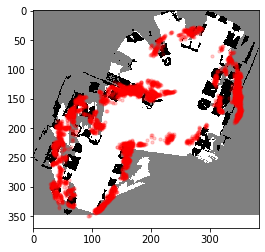

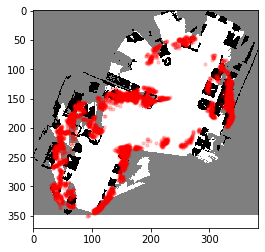

first cc = 0.25778356504205696; first scaled cc = 0.23571110421297878


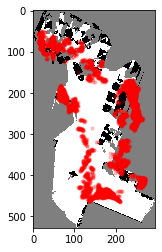

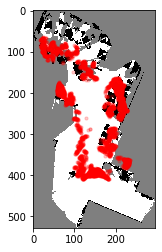

second cc = 0.6666513484640262; second scaled cc = 0.5026882079919714
Sample 13


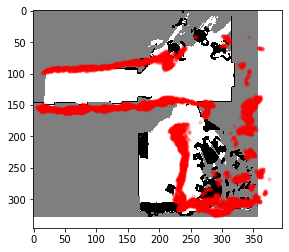

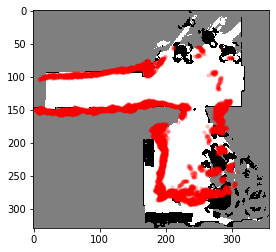

first cc = 0.5078137763297882; first scaled cc = 0.30970144245102


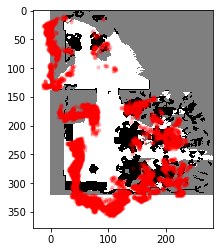

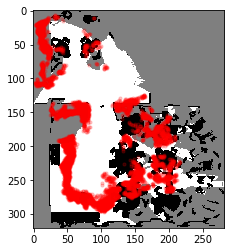

second cc = 0.631640000434997; second scaled cc = 0.35667968707269787
Sample 14


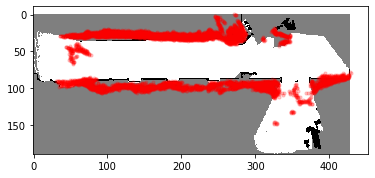

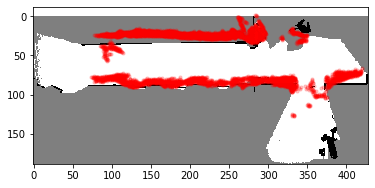

first cc = 0.3800206788567421; first scaled cc = 0.34375688681747296


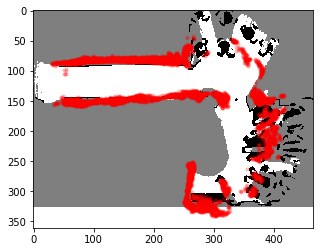

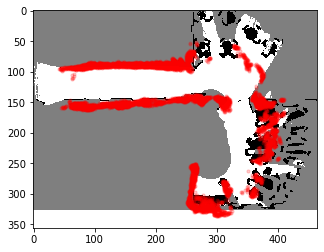

second cc = 0.29454881475495975; second scaled cc = 0.218884599884724
Sample 15


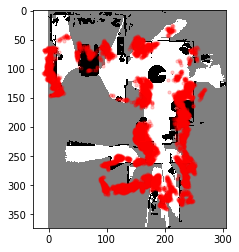

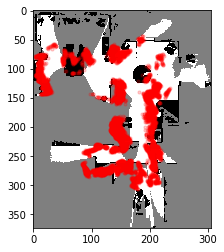

first cc = 0.4016461066983558; first scaled cc = 0.35108559552114327


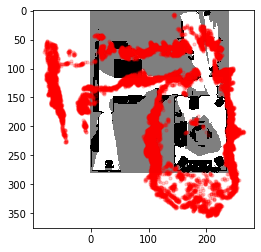

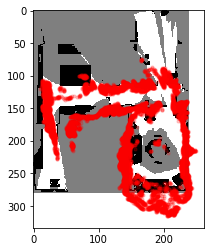

second cc = 1.2240157542850325; second scaled cc = 0.27035947034834085
Sample 16


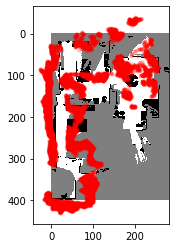

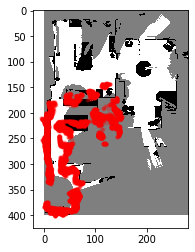

first cc = 0.6708855505021255; first scaled cc = 0.20138754209245846


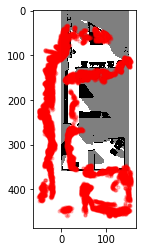

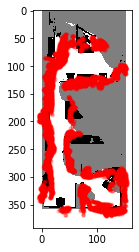

second cc = 1.386033450047284; second scaled cc = 0.2008193943372259
Sample 17


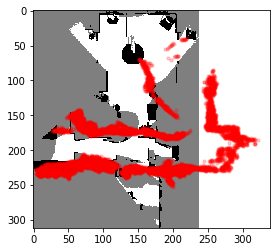

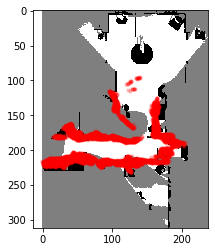

first cc = 1.0824356458516613; first scaled cc = 0.15553084923478253


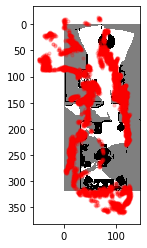

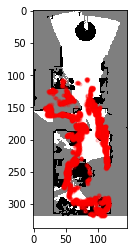

second cc = 0.5450961444164188; second scaled cc = 0.18197958209221526
Sample 18


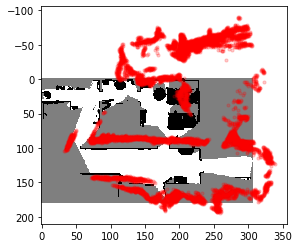

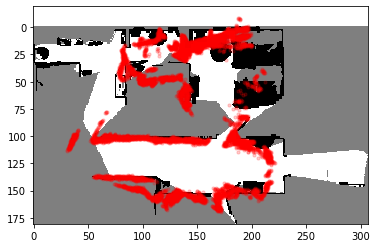

first cc = 1.6053173249586115; first scaled cc = 0.17867711090953653


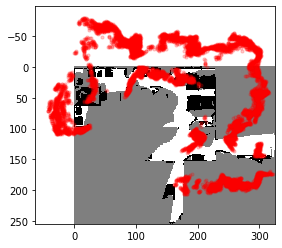

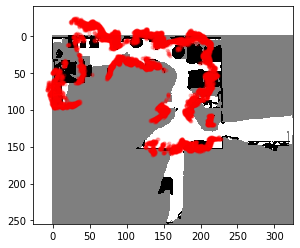

second cc = 1.6837505535903519; second scaled cc = 0.17181746657620744
Sample 19


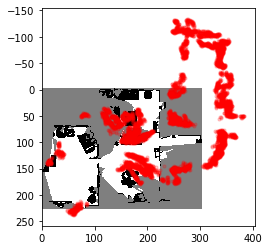

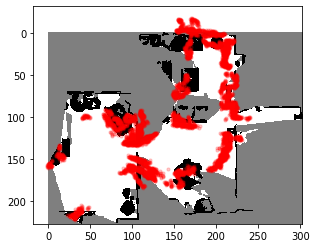

first cc = 2.5959388473341907; first scaled cc = 0.2314057900655423


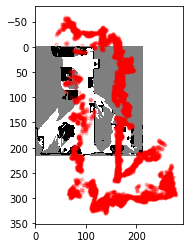

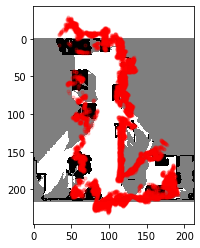

second cc = 2.3584532188552667; second scaled cc = 0.19464035573832858
Sample 20


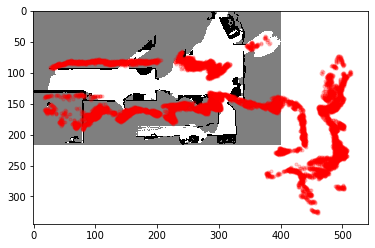

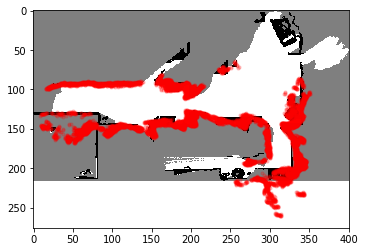

first cc = 3.18581755712147; first scaled cc = 0.21282441446531516


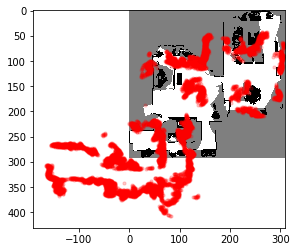

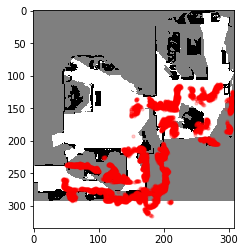

second cc = 2.189891178036436; second scaled cc = 0.4527072669366681


In [380]:
gt_projmaps = {'first': [], 'second': []}
slam_projmaps = {'first': [], 'second': []}
optimap_scales = {'first': [], 'second': []}
for i in range(1, 21):
    print('Sample', i)
    for map_name in ['first', 'second']:
        # read maps
        gt_pcd = np.loadtxt('sample{}/gt_points_{}.txt'.format(i, map_name))
        gt_projmap, shift = projection(gt_pcd)
        slam_projmap = imread('sample{}/fcnn_maps/{}_map.png'.format(i, map_name))
        gt_projmaps[map_name].append(gt_projmap)
        slam_projmaps[map_name].append(slam_projmap)
        with open('sample{}/fcnn_maps/{}_start_position.txt'.format(i, map_name), 'r') as f:
            map_x = float(f.readline().strip())
            map_y = float(f.readline().strip())
            map_z = float(f.readline().strip())
        with open('sample{}/start_pose_{}.txt'.format(i, map_name), 'r') as ff:
            x, y, z = map(float, ff.readline().split())
            angle = float(ff.readline().strip()) + np.pi
            
        # compute metrics
        cc_unscaled = compare(slam_projmap, gt_projmap, x, y, angle + correction[i - 1], map_x, map_y, shift)
        
        cc_scaled = compare(slam_projmap, gt_projmap, x, y, angle + correction[i - 1], map_x, map_y, shift,
                            best_scales['sample{}/{}'.format(i, map_name)])
        
        # show result
        print('{} cc = {}; {} scaled cc = {}'.format(map_name, cc_unscaled, map_name, cc_scaled))
        """
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        plt.title('Groundtruth map')
        plt.imshow(gt_projmap, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title('Slam map')
        plt.imshow(slam_projmap, cmap='gray')
        plt.show()
        """

In [318]:
best_scales

{'sample12/first': 1.05,
 'sample12/second': 1.2,
 'sample13/first': 1.2,
 'sample13/second': 1.2,
 'sample14/first': 1.15,
 'sample14/second': 1.05,
 'sample15/first': 1.2,
 'sample15/second': 1.45,
 'sample16/first': 1.8,
 'sample16/second': 1.3,
 'sample17/first': 1.55,
 'sample17/second': 1.75,
 'sample18/first': 1.6,
 'sample18/second': 1.55,
 'sample19/first': 1.55,
 'sample19/second': 1.5,
 'sample20/first': 1.45,
 'sample20/second': 1.8}

In [278]:
map_x = -0.525
map_y = -12.35

In [285]:
with open('sample{}/fcnn_maps/{}_start_position.txt'.format(i, map_name), 'r') as f:
    map_x = float(f.readline().strip())
    map_y = float(f.readline().strip())
    map_z = float(f.readline().strip())

In [294]:
scale = 1.8
points = np.array((slam_projmap == 0).nonzero()).T.astype(np.float32)
#points /= scale
points[:, 0] += map_y * 20
points[:, 1] += map_x * 20
points_rotated = rotate(points, angle) / scale
points_transformed = points_rotated
points_transformed[:, 0] += -shift[1] + y * 20
points_transformed[:, 1] += -shift[0] + x * 20

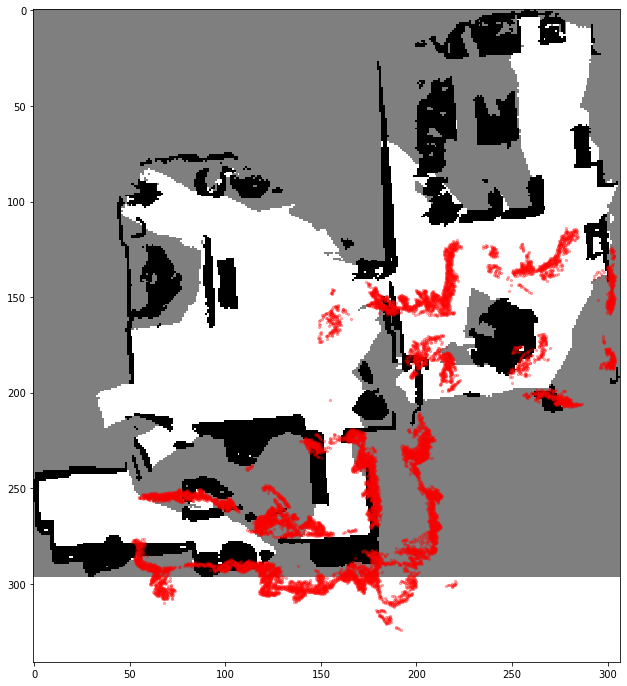

In [295]:
plt.figure(figsize=(12, 12))
plt.imshow(gt_projmap, cmap='gray')
#plt.scatter(gt_points[:, 1], gt_points[:, 0])
plt.scatter(points_transformed[:, 1], points_transformed[:, 0], s=5, alpha=0.3, color='r')

## Estimate for MM1

Sample 5


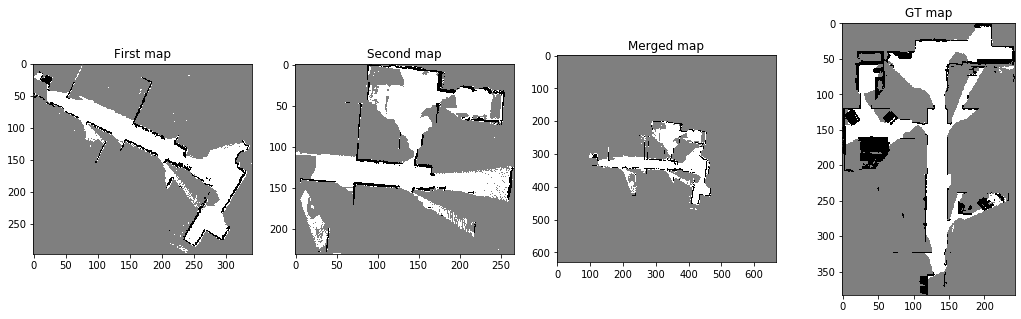

In [125]:
i = 5
print('Sample', i)
gt_pcd_merged = np.loadtxt('sample{}/gt_points_merged.txt'.format(i))
gt_projmap, shift = projection(gt_pcd_merged)
slam_projmap_merged = imread('sample{}/mm3_results/merged_map_fcnn_2d.png'.format(i))
slam_projmap_first = imread('sample{}/first_map_rgbdslam_kinect_2d.png'.format(i))
slam_projmap_second = imread('sample{}/second_map_rgbdslam_kinect_2d.png'.format(i))
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.title('First map')
plt.imshow(slam_projmap_first, cmap='gray')
plt.subplot(1, 4, 2)
plt.title('Second map')
plt.imshow(slam_projmap_second, cmap='gray')
plt.subplot(1, 4, 3)
plt.title('Merged map')
plt.imshow(slam_projmap_merged, cmap='gray')
plt.subplot(1, 4, 4)
plt.title('GT map')
plt.imshow(gt_projmap, cmap='gray')
plt.show()

In [142]:
gt_points = np.array((gt_projmap == 0).nonzero()).T.astype(np.float32)
points = np.array((slam_projmap_merged == 0).nonzero()).T.astype(np.float32)
#points /= 1.4
points = rotate(points, -1.63)
points[:, 1] += -183
points[:, 0] += 495

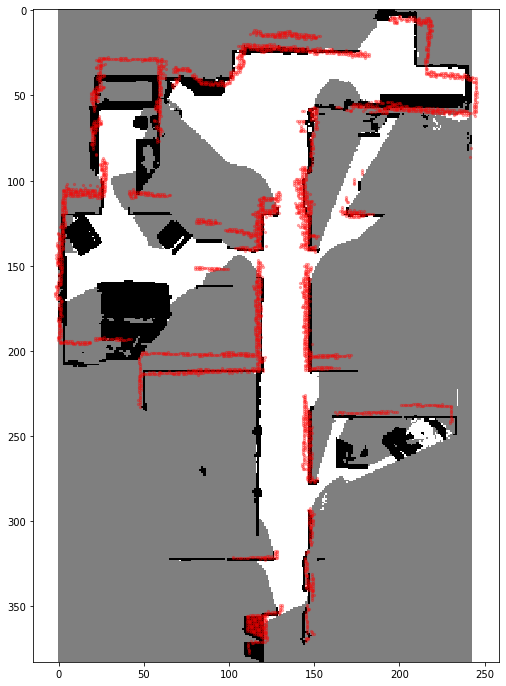

In [143]:
plt.figure(figsize=(12, 12))
plt.imshow(gt_projmap, cmap='gray')
#plt.scatter(gt_points[:, 1], gt_points[:, 0])
plt.scatter(points[:, 1], points[:, 0], s=5, alpha=0.3, color='r')

In [144]:
compare_points(points, gt_points)

0.1466053295924959

## Estimate for MM3

Sample 1
[-80 -72]
(745, 938) (399, 403)


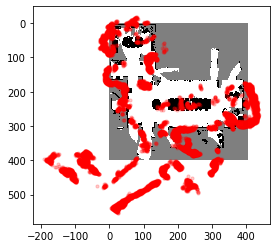

cc = 2.6217051859047618


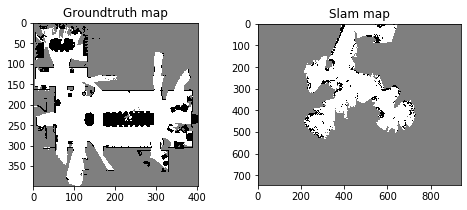

Sample 2
[-81 -37]
(925, 781) (448, 509)


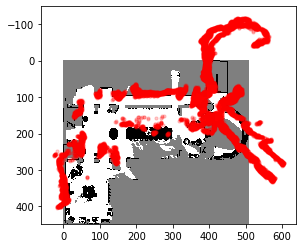

cc = 1.4071218015973401


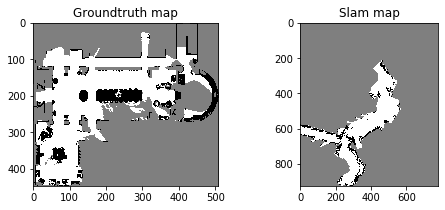

Sample 3
[-28 -36]
(900, 724) (234, 399)


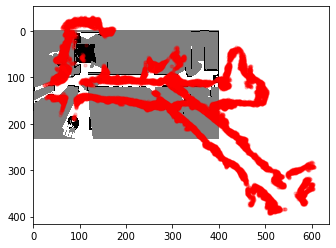

cc = 3.1669920279632184


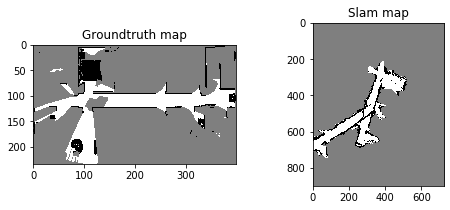

Sample 4
[-81 -59]
(797, 833) (463, 419)


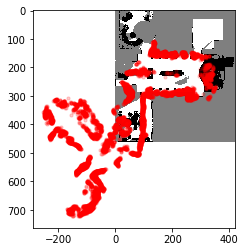

cc = 3.820853135554543


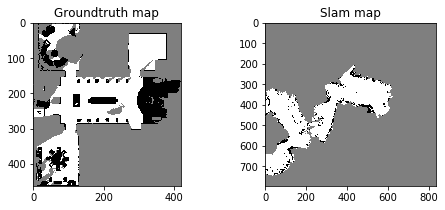

Sample 5
[ -18 -431]
(670, 809) (383, 243)


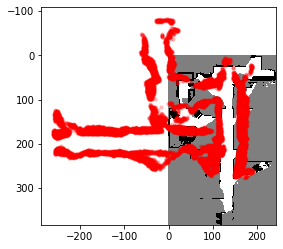

cc = 2.8985025449197304


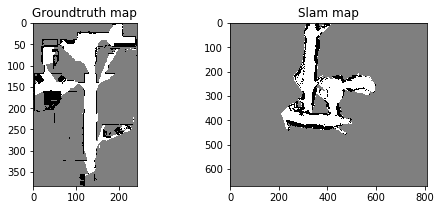

Sample 6
[   7 -430]
(848, 919) (444, 219)


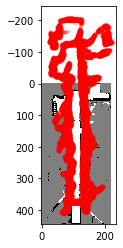

cc = 2.2086379467243957


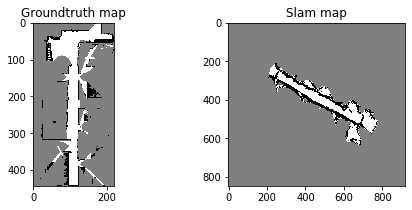

Sample 7
[ -19 -410]
(688, 691) (239, 236)


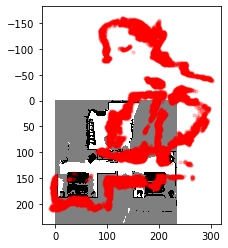

cc = 2.365831618479444


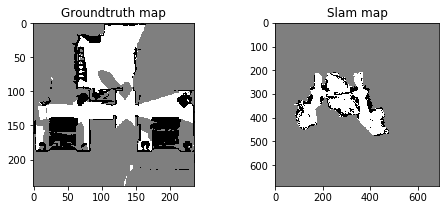

Sample 8
[ -20 -352]
(723, 658) (329, 250)


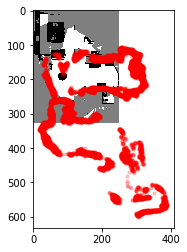

cc = 4.039611667457396


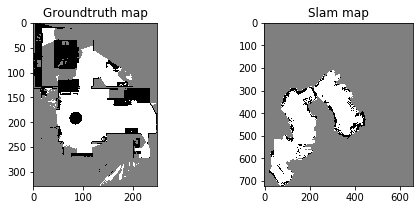

Sample 9
[-175   13]
(616, 602) (211, 245)


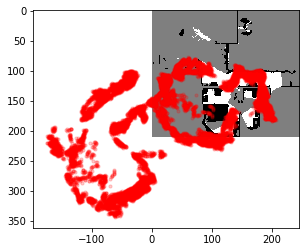

cc = 4.0369871870218095


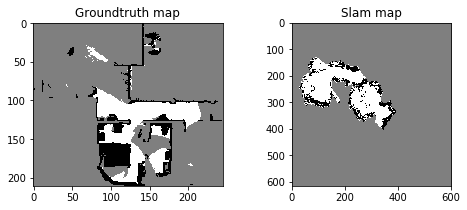

Sample 10
[-163 -170]
(656, 725) (250, 310)


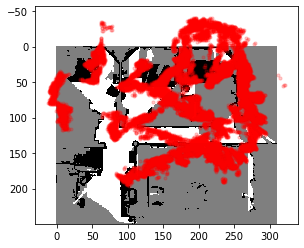

cc = 0.45665499426233236


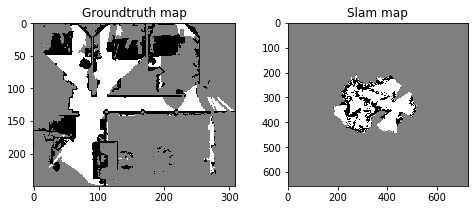

Sample 11
[-167 -170]
(613, 678) (330, 379)


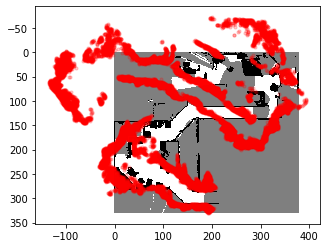

cc = 1.8640879369226844


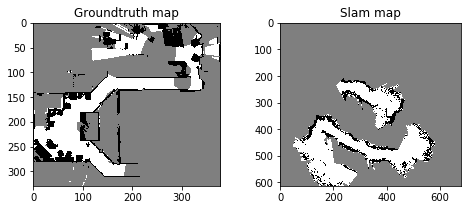

Sample 12
[-153 -514]
(762, 807) (528, 407)


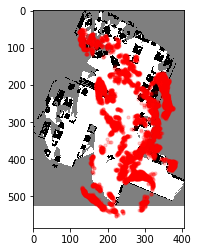

cc = 0.8472592629130224


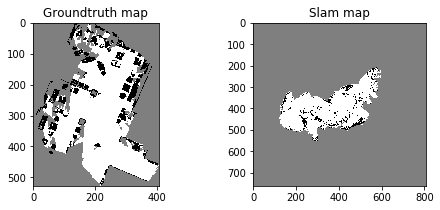

Sample 13
[647  -8]
(702, 783) (329, 425)


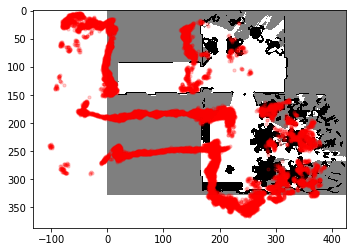

cc = 1.53727806306395


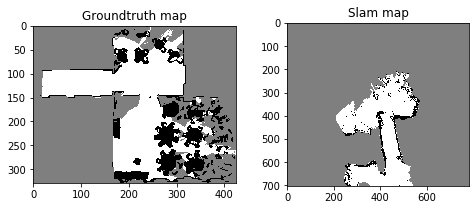

Sample 14
[535  -6]
(829, 719) (327, 484)


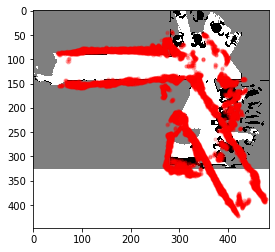

cc = 0.6707892427275768


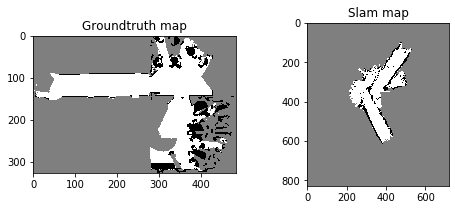

Sample 15
[-378 -139]
(770, 768) (397, 314)


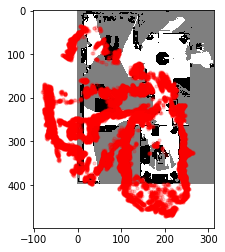

cc = 1.0490859640261663


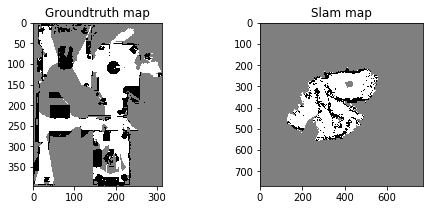

Sample 16
[-378 -143]
(758, 835) (400, 284)


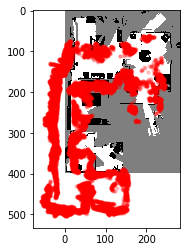

cc = 1.398143487774714


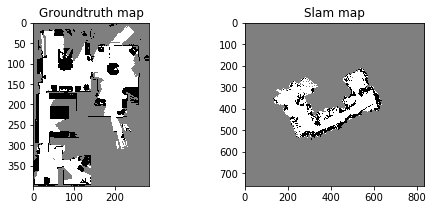

Sample 17
[-325  -91]
(687, 772) (349, 238)


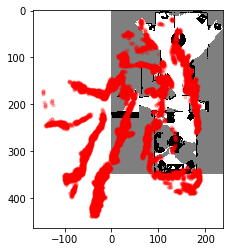

cc = 2.47759265147236


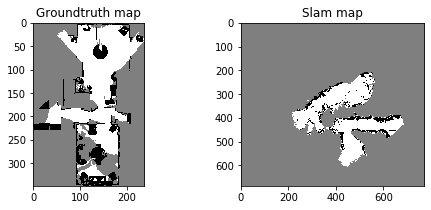

Sample 18
[-231  -98]
(698, 802) (255, 326)


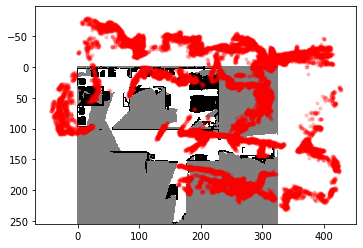

cc = 2.3072556621524836


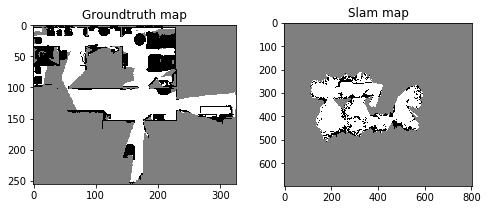

Sample 19
[  34 -167]
(797, 713) (228, 319)


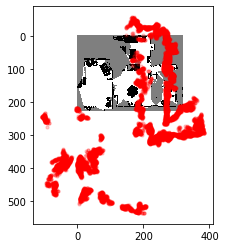

cc = 4.726766449171951


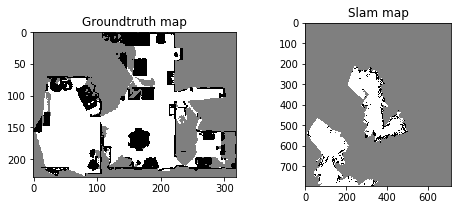

Sample 20
[-200 -166]
(932, 767) (293, 465)


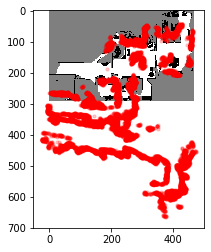

cc = 5.035604342835892


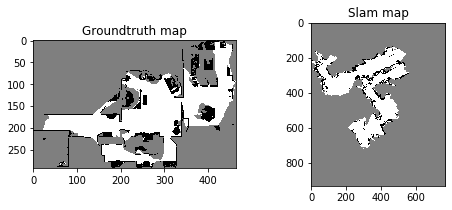

In [441]:
metrics = []
for i in range(1, 21):
    print('Sample', i)
    gt_pcd = np.loadtxt('sample{}/gt_points_merged.txt'.format(i))
    gt_projmap, shift = projection(gt_pcd)
    print(shift)
    slam_projmap = imread('sample{}/mm3_results/merged_map_fcnn_2d.png'.format(i))
    with open('sample{}/fcnn_maps/second_start_position.txt'.format(i), 'r') as f:
            map_x = float(f.readline().strip())
            map_y = float(f.readline().strip())
            map_z = float(f.readline().strip())
    with open('sample{}/start_pose_second.txt'.format(i), 'r') as ff:
        x, y, z = map(float, ff.readline().split())
        angle = float(ff.readline().strip()) + np.pi
    print(slam_projmap.shape, gt_projmap.shape)
    cc = compare(slam_projmap, gt_projmap, x, y, angle + correction[i - 1], map_x - 10, map_y - 10, shift)
    metrics.append(cc)
    print('cc = {}'.format(cc))
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.title('Groundtruth map')
    plt.imshow(gt_projmap, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Slam map')
    plt.imshow(slam_projmap, cmap='gray')
    plt.show()

In [355]:
x, y

(-8.742801666259766, -1.0238778591156006)

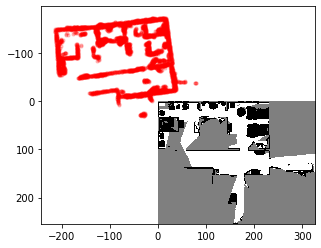

In [332]:
slam_points, gt_points = align_points(slam_projmap, gt_projmap, x, y, angle, map_x - 10, map_y - 10, shift, scale=1)

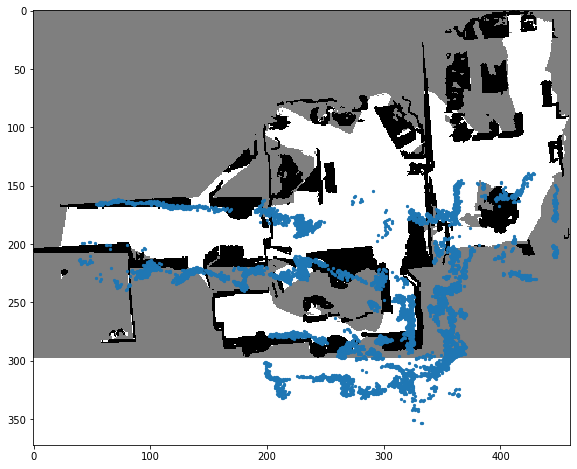

In [326]:
plt.figure(figsize=(13, 8))
plt.imshow(gt_projmap, cmap='gray')
plt.scatter(slam_points[:, 1], slam_points[:, 0], s=5)